In [1]:
import bz2
import numpy as np
import pandas as pd
import array
import gc 
import matplotlib.pyplot as plt

In [27]:
def pulses(file_path):
    """
    Versión optimizada:
    - Usa bz2 (backend C) en lugar de subprocess.
    - Evita operaciones de string innecesarias.
    """
    data = []
    presion = 0.0
    clocks = 0
    current_pulse = []
    nl = 0
    cuentas = 0 
    cont = 0
    tim_pt = []
    tim_otro = []
    with bz2.open(file_path, 'rt') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            if line.startswith('#'):
                if len(line) > 2 and line[2] == 't':
                    tval = int(line[6:])   
                    if tval<clocks:
                        tval+=125000000
                    
                    if nl == 32:
                        current_pulse.append((tval - clocks) * 8)
                        data.append(current_pulse)
                    
                    if(tval-clocks)==79:
                        tim_pt.append(tval)
                        tim_otro.append(clocks)
                       #print(tval,clocks)
        
                    clocks = int(line[6:])
                    nl = 0 
                    current_pulse = []
                
                if len(line) > 2 and line[2:4] == 'r1':
                    try:
                        cuentas = cuentas + float(line[5:8])
                    except ValueError:
                        pass
                elif len(line) > 5 and line[4] == 'p':
                    try:
                        presion += float(line[6:14])
                    except ValueError:
                        pass
                continue

            if nl < 32:
                try:
                    current_pulse.append(int(line.split()[0]))
                except ValueError:
                    continue
            nl += 1

    if not data:
        return None, None

    df = pd.DataFrame(np.array(data, dtype=np.float32),
                      columns=[*range(32), "deltaTime"])
    presion /= 3600.0
    return df, presion,cuentas,tim_pt,tim_otro

In [3]:
# -------------------------
# 2. Funciones vectorizadas
# -------------------------

def BaseLine(df):
    num = abs(df.iloc[:, :32].min(axis=1))
    df.iloc[:, :32] = df.iloc[:, :32].add(num, axis=0)
    return df


def Peak_Position(df, sat=False, bin_sat_position=None):
    
    
    df['Peak_Position'] = df.iloc[:, :32].values.argmax(axis=1)
    if sat and bin_sat_position is not None:
        df = df[df['Peak_Position'] < bin_sat_position].reset_index(drop=True)
    
    df['Peak'] = df.iloc[:,0:32].max(axis=1)
    
    return df

def A3CAP(df):
    arr = df.iloc[:, :32].to_numpy(copy=False)
    peak = df['Peak_Position'].to_numpy()
    idx = np.arange(len(arr))
    mean_next3 = (arr[idx, peak + 1] + arr[idx, peak + 2] + arr[idx, peak + 3]) / 3
    df['A3CAP'] = ((arr[idx, peak] - mean_next3) * 100 / arr[idx, peak]).astype(np.int16)
    return df


def SPC(df, offset, name):
    arr = df.iloc[:, :32].to_numpy(copy=False)
    peak = df['Peak_Position'].to_numpy()
    idx = np.arange(len(arr))
    df[name] = ((arr[idx, peak] - arr[idx, peak + offset]) * 100 / arr[idx, peak]).astype(np.int16)
    return df


def charge(df):
    arr = df.iloc[:, :32].to_numpy(copy=False)
    df['Charge'] = arr.sum(axis=1)
    df = df[df['Charge'] >= 0].reset_index(drop=True)
    return df

In [4]:
def process_file(file_path, sat=False, bin_sat_position=None):
    df,presion,cuentas = pulses(file_path)
    df = BaseLine(df)
    if df is not None:
        mask =  (df['deltaTime'] <1.5E7) 
        df = df[mask]
        df = Peak_Position(df, sat, bin_sat_position)
        df = A3CAP(df)
        df = SPC(df, 3, "SPC-24")
        df = SPC(df, 4, "SPC-32")
        df = charge(df)
        return df,presion,cuentas
    else:
        return None

In [28]:
base_date = '2024_04'
base_path_data = '/eos/user/d/dmerizal/SWAN_projects/LAGO/Datos_ICRC/'
hour = 0
day = 1
hour_str = f"{hour:02d}"
day_str = f"{day:02d}"

file_path = f"{base_path_data}jaguarito_nogps_{base_date}_{day_str}_{hour_str}h00.dat.bz2"
print(file_path)
df,presion,cuentas,tim_pt,tim_otro = pulses(file_path)
#df,presion,cuentas=process_file(file_path, sat=True, bin_sat_position=20)


/eos/user/d/dmerizal/SWAN_projects/LAGO/Datos_ICRC/jaguarito_nogps_2024_04_01_00h00.dat.bz2


In [ ]:
df

In [ ]:
(len(df_1)-len(df_1[df_1['SPC-24']<85]))/len(df_1)

In [ ]:
cuentas, bines = np.histogram(df_1['SPC-24'].to_numpy(), bins=100)
centros = 0.5 * (bines[1:] + bines[:-1])
plt.figure(figsize=(10, 5))  # tamaño de la figura
plt.scatter(centros, cuentas, s=50, color='blue',edgecolor='black')
plt.xlabel('Porcentajes')
plt.ylabel('Frecuencia')
plt.title('Histograma SPC-24')
plt.grid(True)
plt.show()

In [ ]:
(len(df_1)-len(df_1[df_1['SPC-32']<90]))/len(df_1)

In [ ]:
cuentas, bines = np.histogram(df_1['SPC-32'].to_numpy(), bins=100)
centros = 0.5 * (bines[1:] + bines[:-1])
plt.figure(figsize=(10, 5))  # tamaño de la figura
plt.scatter(centros, cuentas, s=50, color='blue',edgecolor='black')
plt.xlabel('Porcentajes')
plt.ylabel('Frecuencia')
plt.title('Histograma SPC-32')
plt.grid(True)
plt.show()

In [ ]:
(len(df_1)-len(df_1[df_1['A3CAP']<80]))/len(df_1)

In [ ]:
cuentas, bines = np.histogram(df_1['A3CAP'].to_numpy(), bins=100)
centros = 0.5 * (bines[1:] + bines[:-1])
plt.figure(figsize=(10, 5))  # tamaño de la figura
plt.scatter(centros, cuentas, s=50, color='blue',edgecolor='black')
plt.xlabel('Porcentajes')
plt.ylabel('Frecuencia')
plt.title('Histograma SPC-32')
plt.grid(True)
plt.show()

In [ ]:
#def Charge_Histogram_All(df,df_3, df_4,cluster_col='Cluster', bin_width=7):
def Charge_Histogram_All(df,cluster_col='Cluster',bin_width=7):
    """
    Generates an histogram from the column 'Charge':
    - Global all data
    - Splits the data according to each cluster.

    Parameters:
    - df: DataFrame with the column 'Charge' could be cluster_col (ej: 0,1,2)
    - cluster_col: name of the cluster
    - bin_width: the width of the bins
    """
    plt.figure(figsize=(15, 8))

    # --- bins compartidos para todos ---

    min_val, max_val = df['Charge'].min(), df['Charge'].max()
    bins = np.arange(min_val, max_val + bin_width, bin_width)

    # --- histograma global ---
    counts, bin_edges = np.histogram(df['Charge'], bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.semilogy(bin_centers, counts, color='black', lw=3,alpha=0.6, label="Total", zorder=5)

    #counts_3, bin_edges_3 = np.histogram(df_3['Charge'], bins=bins)
    #bin_centers_3 = (bin_edges_3[:-1] + bin_edges_3[1:]) / 2
    #plt.semilogy(bin_centers_3, counts_3, color='red', lw=3,alpha=0.3, label="Electrons", zorder=5)

    #counts_4, bin_edges_4 = np.histogram(df_4['Charge'], bins=bins)
    #bin_centers_4 = (bin_edges_3[:-1] + bin_edges_3[1:]) / 2
    #plt.semilogy(bin_centers_4, counts_4, color='green', lw=3,alpha=0.3, label="Muons", zorder=5)

    # --- histogramas por cluster ---
    #clusters = sorted(df[cluster_col].unique())
    #for c in clusters:
        #subset = df[df[cluster_col] == c]['Charge'].to_numpy()
        #counts, bin_edges = np.histogram(subset, bins=bins)
        #bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        #plt.semilogy(bin_centers, counts, label=f"Cluster {c}", alpha=1, zorder=4)

    plt.ylabel("Number of Entries", fontsize=20)
    plt.xlabel("Charge[ADC]", fontsize=20)
    #plt.title("Charge Histogram", fontsize=20)
    plt.grid(True)
    plt.legend(fontsize='20')
    plt.show()

In [ ]:
mask = df['Charge']<25000

In [ ]:
Charge_Histogram_All(df[mask],cluster_col='Cluster',bin_width=2)

In [41]:
# Cargar el archivo ignorando líneas vacías o comentarios
df_anna = pd.read_csv("l1_v5_jaguarito_nogps_2024_04_01_00h00.tim", 
                 delim_whitespace=True, 
                 header=None, 
                 comment='#', 
                 usecols=[0, 1])

# Renombrar columnas
df_anna.columns = ['x', 'y']

# Mostrar las primeras filas
print(df_anna.head())

    x  y
0   0  0
1   8  0
2  16  0
3  24  0
4  32  0


/tmp/ipykernel_462/879835969.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_anna = pd.read_csv("l1_v5_jaguarito_nogps_2024_04_01_00h00.tim",


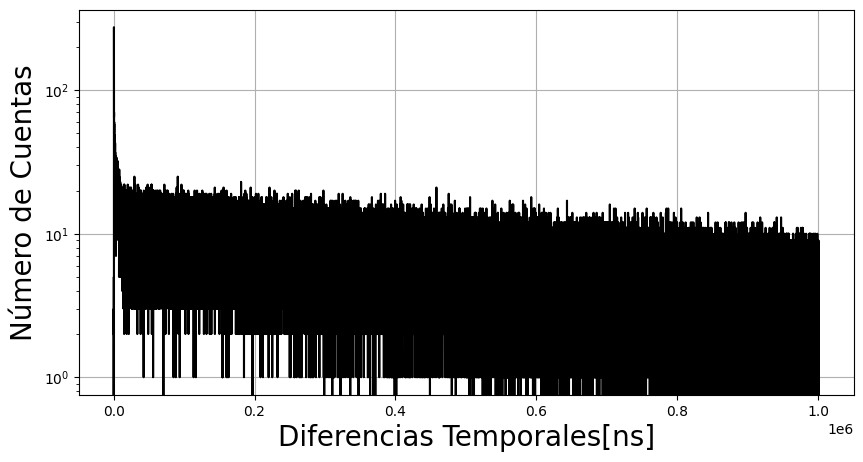

In [19]:
mask = df['deltaTime']<=999992
cuentas, bines = np.histogram(df['deltaTime'][mask].to_numpy(), bins=124963)
centros = 0.5 * (bines[1:] + bines[:-1])
plt.figure(figsize=(10, 5))  # tamaño de la figura
#plt.scatter(centros, cuentas, s=10, color='blue',edgecolor='black')
plt.semilogy(centros, cuentas, color='black')
plt.xlabel('Diferencias Temporales[ns]',fontsize=20)
plt.ylabel('Número de Cuentas',fontsize=20)
plt.grid(True)
plt.show()

In [8]:
cuentas_anna = df_anna[df_anna['x']>=288]['y'].to_numpy()

In [9]:
len(bines)-len(cuentas_anna)

0

In [10]:
len(cuentas_anna)

124964

In [11]:
125000-36

124964

In [18]:
bines_anna=df_anna[df_anna['x']>=288]['x'].to_numpy()

In [17]:
bines[0:10]

array([288, 296, 304, 312, 320, 328, 336, 344, 352, 360])

In [21]:
for i in range (0,1000):
    print(i,cuentas[i]-cuentas_anna[i],bines[i])

0 0 288.0
1 0 296.0
2 0 304.0
3 0 312.0
4 0 320.0
5 0 328.0
6 0 336.0
7 0 344.0
8 0 352.0
9 0 360.0
10 0 368.0
11 0 376.0
12 0 384.0
13 0 392.0
14 0 400.0
15 0 408.0
16 0 416.0
17 0 424.0
18 0 432.0
19 0 440.0
20 0 448.0
21 0 456.0
22 0 464.0
23 0 472.0
24 0 480.0
25 0 488.0
26 0 496.0
27 0 504.0
28 0 512.0
29 0 520.0
30 0 528.0
31 0 536.0
32 0 544.0
33 0 552.0
34 0 560.0
35 0 568.0
36 0 576.0
37 0 584.0
38 0 592.0
39 0 600.0
40 1 608.0
41 0 616.0
42 0 624.0
43 4 632.0
44 2 640.0
45 0 648.0
46 0 656.0
47 0 664.0
48 0 672.0
49 0 680.0
50 1 688.0
51 0 696.0
52 2 704.0
53 1 712.0
54 0 720.0
55 1 728.0
56 0 736.0
57 0 744.0
58 0 752.0
59 1 760.0
60 1 768.0
61 1 776.0
62 0 784.0
63 1 792.0
64 1 800.0
65 0 808.0
66 0 816.0
67 0 824.0
68 0 832.0
69 1 840.0
70 0 848.0
71 1 856.0
72 1 864.0
73 1 872.0
74 0 880.0
75 0 888.0
76 1 896.0
77 0 904.0
78 0 912.0
79 0 920.0
80 0 928.0
81 0 936.0
82 0 944.0
83 0 952.0
84 0 960.0
85 0 968.0
86 1 976.0
87 0 984.0
88 1 992.0
89 1 1000.0
90 0 1008.0
91 0 10

In [24]:
632/8

79.0

In [ ]:
cuentas_anna[38:42]

In [ ]:
#40 #43 #44 #50 #52
df_filtrado = df_anna[df_anna['x'] >= 288].reset_index(drop=True)
df_filtrado[42:45]

In [ ]:
df_anna[40:42]

In [ ]:
df

In [ ]:
999992-288

In [ ]:
999704/8

In [25]:
# Cargar el archivo ignorando líneas vacías o comentarios
df_anna = pd.read_csv("Prueba.txt", 
                 delim_whitespace=True, 
                 header=None, 
                 comment='#', 
                 usecols=[0, 1])

# Renombrar columnas
df_anna.columns = ['x', 'y']

# Mostrar las primeras filas
print(df_anna.head())

           x          y
0  119435429  119435350
1   67446087   67446008
2   29350075   29349996
3   31579000   31578921
4   24984604   24984525


/tmp/ipykernel_462/2618449163.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_anna = pd.read_csv("Prueba.txt",


In [34]:
x_anna = df_anna['x'].to_numpy()

In [36]:
sum(tim_pt-x_anna)

np.int64(0)

In [38]:
len(tim_otro)

65

In [39]:
y_anna = df_anna['y'].to_numpy()

In [40]:
tim_otro-y_anna

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [46]:
df_anna[79:80]

,x,y
79,632,61
